In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import sklearn
import pandas
import glob
import nibabel as nib
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms 
from segmentation_models_pytorch.utils.losses import DiceLoss
from torch.utils.data import DataLoader 
from sklearn.model_selection import train_test_split
import catalyst

/Users/aayush/SOTA_segment/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# We will be implementing several state-of-the-art architectures 

The dataset used will be ACDC. 

Models used will be 

1. Unet
2. Unet++
3. DeepLabV3
4. TransUnet
5. SwinUnet
6. TransFuse
7. DuAT



## DRIVE(Digital Retinal Images for Vessel Extraction) 


In [2]:
img = glob.glob('Drive eye ball/training/images/*.tif')
label = glob.glob('Drive eye ball/training/1st_manual/*.gif')
img.sort()
label.sort()

In [3]:
len(label)

20

In [4]:
transform = transforms.Compose([
    transforms.Resize((608,576)),

])

In [5]:
import torchvision.transforms as transforms
from PIL import Image
image  = []
mask = []
p = transforms.PILToTensor()
for i in range(len(img)):
    temp = Image.open(img[i])
    temp_mask = Image.open(label[i]).convert('1')

    temp = transform(temp)
    temp_mask = transform(temp_mask)
    temp = transforms.functional.to_tensor(temp)
    temp_mask = transforms.functional.to_tensor(temp_mask)
    
    image.append(temp)
    mask.append(temp_mask)


In [6]:
from torch.nn.utils.rnn import pad_sequence
image = pad_sequence(image , True)
mask = pad_sequence(mask , True)

In [7]:
for i in range(len(img)):
    mask[i] = (mask[i])
    print(mask[i].shape)

torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])
torch.Size([1, 608, 576])


In [8]:
image[1].shape

torch.Size([3, 608, 576])

In [9]:
mask[5].shape

torch.Size([1, 608, 576])

In [10]:
def visualize(image, mask):
    '''
    Visualize the difference between original and augmentated image

    Parameters
    ------------
    image : The new augmentated image
    mask : The corresponding mask
    original_image : The original Image that has been transformed
    original_mask : The mask of original Image that has been transformed

    Return
    ---------
    None

    '''
    fontsize = 18
    fig = plt.figure(figsize=((10, 10)))

    fig.add_subplot(2, 2, 1)

    plt.imshow(image)
    print(image.shape)
    plt.title('Original image', fontsize=fontsize)

    fig.add_subplot(2, 2, 2)
    plt.imshow(mask , cmap = 'gray')
    plt.title('Original mask', fontsize=fontsize)

    



In [11]:
image[0].shape

torch.Size([3, 608, 576])

/var/folders/m8/3n260qc114151vg3pxqk55km0000gn/T/ipykernel_9799/2972553907.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  visualize(image[i].T, mask[i].T)


torch.Size([576, 608, 3])
torch.Size([576, 608, 3])
torch.Size([576, 608, 3])
torch.Size([576, 608, 3])


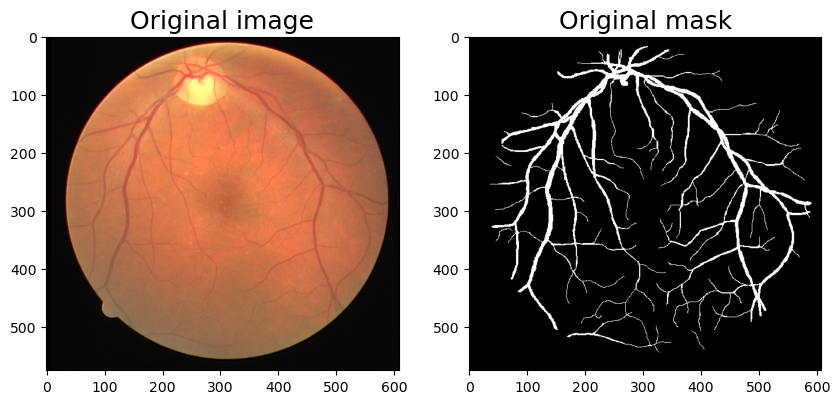

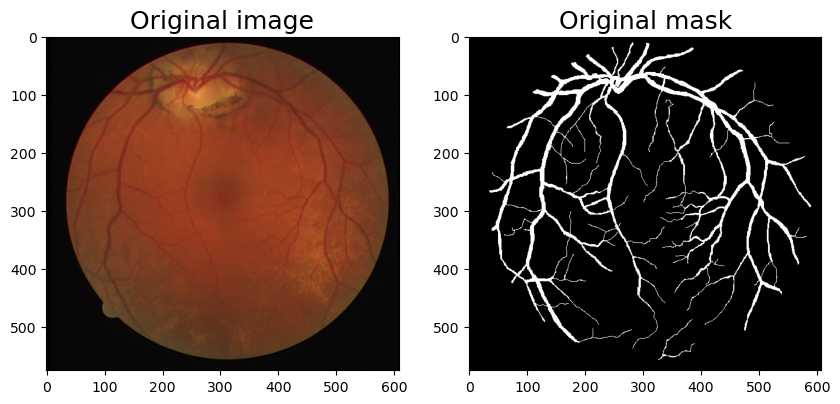

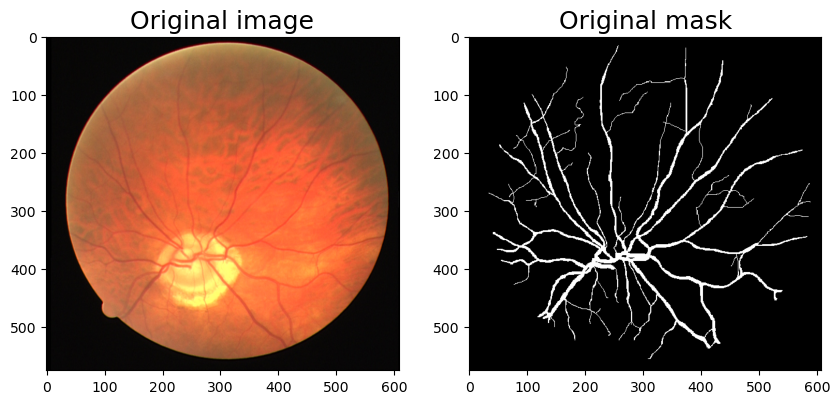

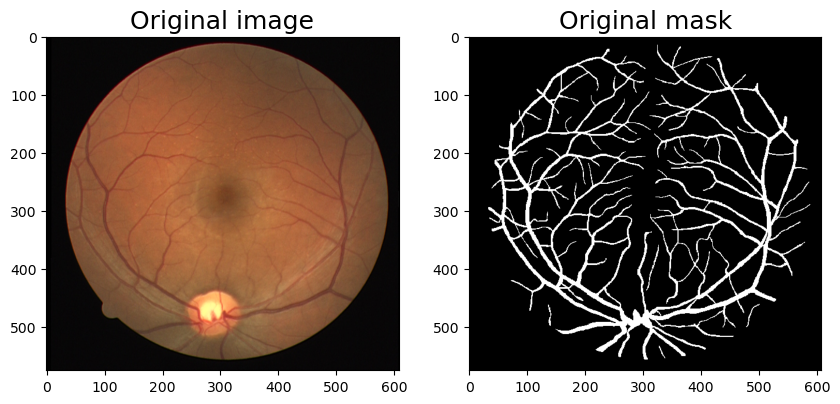

In [12]:
for i in range(0,len(image),5):
    visualize(image[i].T, mask[i].T)

In [13]:

X_train, X_valid, y_train, y_valid = train_test_split(image, mask, test_size=0.33, random_state=42)

In [14]:
training_loader = DataLoader(list(zip(X_train , y_train)), batch_size=4, shuffle=True)
validation_loader = DataLoader(list(zip(X_valid , y_valid)), batch_size=4, shuffle=False)

In [15]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /Users/aayush/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [16]:
# loss = DiceLoss()
# loss.__name__ = 'Dice_loss'

In [20]:
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [24]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 0:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [25]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('./save'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1 loss: 0.03422870337963104
LOSS train 0.03422870337963104 valid 0.3823736906051636
EPOCH 2:
  batch 1 loss: 0.022010831534862517
LOSS train 0.022010831534862517 valid 0.28812891244888306
EPOCH 3:
  batch 1 loss: 0.02231539934873581
LOSS train 0.02231539934873581 valid 0.2369024157524109
EPOCH 4:
  batch 1 loss: 0.02157856523990631
LOSS train 0.02157856523990631 valid 0.20111702382564545
EPOCH 5:
  batch 1 loss: 0.023281028866767882
LOSS train 0.023281028866767882 valid 0.1912125200033188


In [26]:
output = model(X_train)

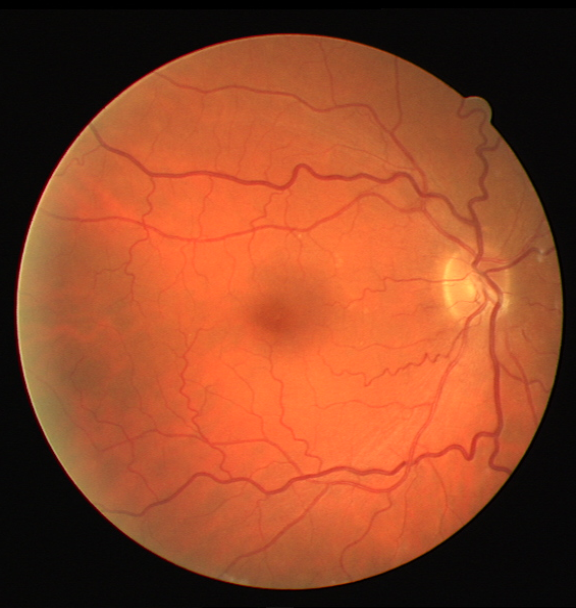

In [37]:
img2 = transform__(image[1])
img2

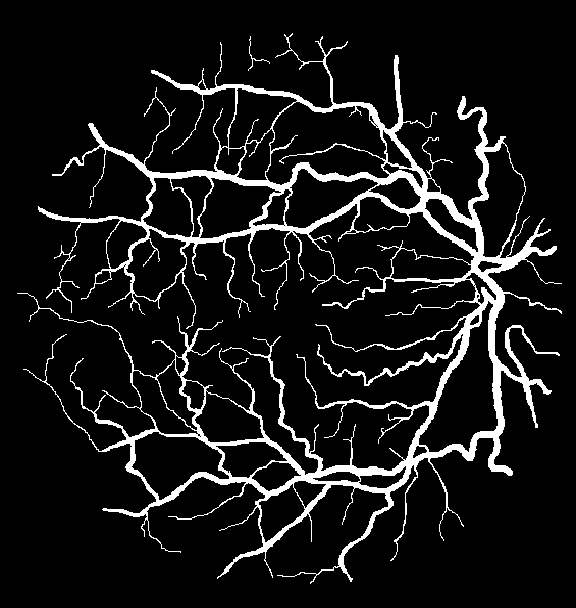

In [36]:
img1 = transform__(mask[1])
img1

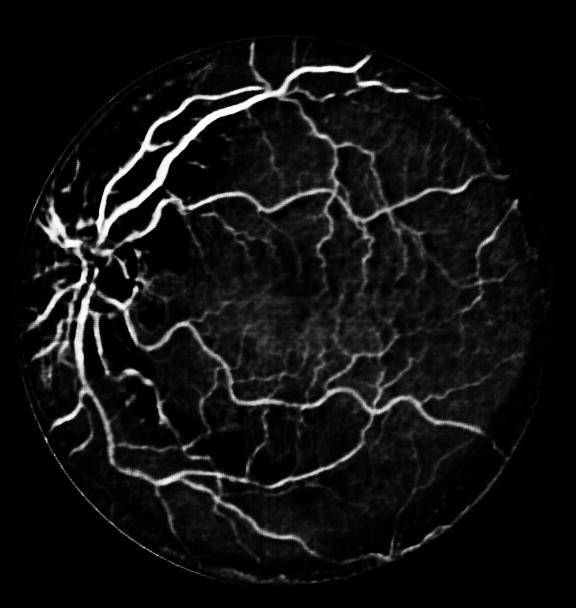

In [35]:

transform__ = transforms.ToPILImage()
img = transform__(output[1])
img

In [ ]:
max_score = 0
for i in range(0, 40):
    
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(training_loader)
    valid_logs = valid_epoch.run(test_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
    verbose=True,


In [193]:
import torch
from torch.nn import functional as F

class CustomRunner(Runner):
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveMetric(compute_on_call=False)
            for key in ["loss", "mae"]
        }

    def handle_batch(self, batch):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `train()`.
        x, y = batch

        y_pred = self.model(x) # Forward pass

        # Compute the loss value
        loss = F.mse_loss(y_pred, y)

        # Update metrics (includes the metric that tracks the loss)
        self.batch_metrics.update({"loss": loss, "mae": F.l1_loss(y_pred, y)})
        for key in ["loss", "mae"]:
            self.meters[key].update(self.batch_metrics[key].item(), self.batch_size)

        if self.is_train_loader:
            # Compute gradients
            loss.backward()
            # Update weights
            # (the optimizer is stored in `self.state`)
            self.optimizer.step()
            self.optimizer.zero_grad()
    
    def on_loader_end(self, runner):
        for key in ["loss", "mae"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)

In [194]:
loaders = {
            "train": torch.utils.data.DataLoader(list(zip(X_train , y_train)), batch_size=4, shuffle=True),
            "valid": torch.utils.data.DataLoader(list(zip(X_test , y_test)), batch_size=4, shuffle=False),

        }

In [293]:
runner = SupervisedRunner()
runner.train(
    model=model,

    optimizer=optimizer,

    loaders=loaders,
    logdir='savedmodel',
    num_epochs=2,
    verbose=True,
)

1/2 * Epoch (train):   0%|                                | 0/4 [00:00<?, ?it/s]

RuntimeError: expected scalar type Byte but found Float

In [294]:

runner = CustomRunner()
runner.train(
  model=model, 
  optimizer=optimizer, 
  loaders=loaders, 
  num_epochs=5,
  verbose=True, # you can pass True for more precise training process logging
  timeit=False, # you can pass True to measure execution time of different parts of train process
)

AttributeError: 'list' object has no attribute 'AdditiveMetric'